![image.png](https://i.imgur.com/a3uAqnb.png)

# Variational Autoencoder (VAE) for Anime Portrait Generation
- **Images**: Anime-style portrait images **(64x64, RGB)**
- **Classes**: Various anime characters, but for VAE we **ignore labels**
- **Shape**: `(batch_size, 3, 64, 64)` → 3 RGB channels



## 1️⃣ Dataset Class

In [1]:
%pip install fsspec==2023.6.0

In [2]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# Custom Dataset class for Hugging Face dataset
class AnimeDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        elif not isinstance(image, Image.Image):
            image = Image.open(image).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, 0  # Return dummy label for compatibility

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor(),        # Convert to tensor [0,1]
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1,1]
])

In [5]:
hf_dataset = load_dataset("quindici1515/Anime_style_portrait_dataset", split="train")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
train_dataset = AnimeDataset(hf_dataset, transform=transform)


In [7]:
batch_size =  256 # Reduced batch size for larger images
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Check dataset size
print(f"Training samples: {len(train_dataset)}")

Training samples: 4000


### Let's display some images

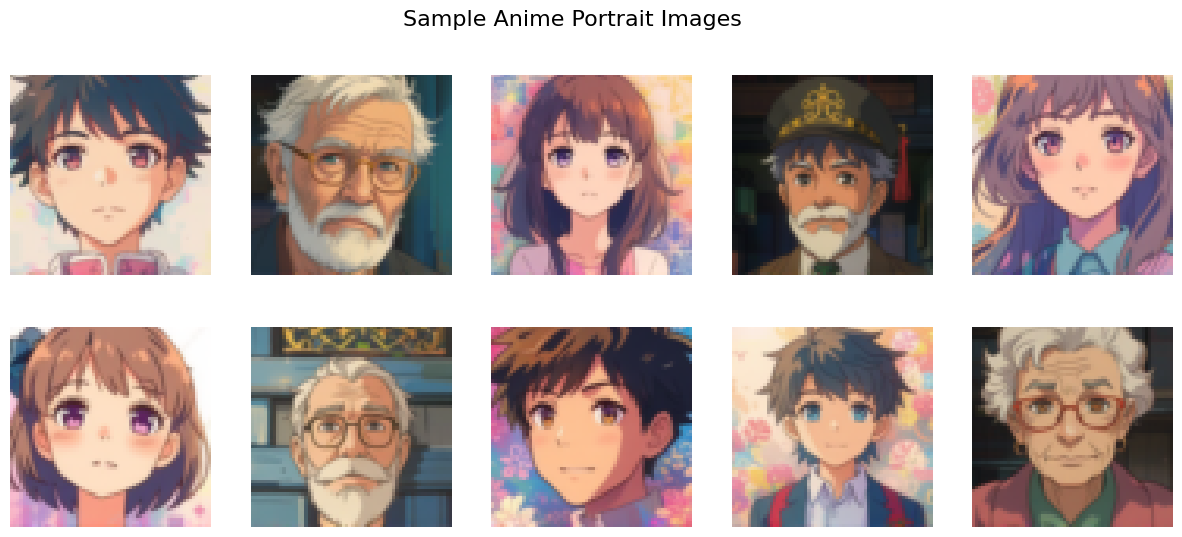

Shape of one image tensor: torch.Size([3, 64, 64])


In [8]:
# Get a batch of training data
data_iter = iter(train_loader)
images, _ = next(data_iter)  # Labels are ignored in VAE

# Denormalize images for display
def denormalize(tensor):
    return (tensor * 0.5) + 0.5  # Convert from [-1,1] to [0,1]

# Show images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    img = denormalize(images[i]).permute(1, 2, 0)  # Change from (C,H,W) to (H,W,C)
    img = torch.clamp(img, 0, 1)  # Ensure values are in [0,1]

    ax.imshow(img.numpy())
    ax.axis("off")

plt.suptitle("Sample Anime Portrait Images", fontsize=16)
plt.show()

# Show shape of one image
print("Shape of one image tensor:", images[0].shape)  # Expected: (3, 64, 64)

## 2️⃣ Model Class

# **📌 Variational Autoencoder (VAE) Model**
A **Variational Autoencoder (VAE)** is a generative model that learns to **encode data into a probabilistic latent space** and **decode it back to reconstruct the original data**.

## **🔹 Key Differences from Standard Autoencoder**
1️⃣ **Probabilistic Encoding**
   - Instead of deterministic encoding, VAE learns **mean (μ) and log-variance (σ²)** of latent distribution
   - Uses **reparameterization trick** to sample from learned distribution

2️⃣ **KL Divergence Loss**
   - Regularizes latent space to follow standard normal distribution
   - Enables smooth interpolation and generation

3️⃣ **Better Generation**
   - Can generate new samples by sampling from prior distribution
   - More structured and meaningful latent space

![VAE Architecture](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*r1R0cxCnErWgE0P4Q-hI0Q.jpeg)

## **📌 Expected Input & Output Shapes**
- **Input:** `(batch_size, 3, 64, 64)`
- **Encoded μ, σ:** `(batch_size, latent_dim)`
- **Decoded Output:** `(batch_size, 3, 64, 64)`

In [9]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Enhanced Encoder with more layers
        self.encoder = nn.Sequential(
            # Input: (3, 64, 64)
            nn.Conv2d(3, 32, 4, 2, 1),      # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 32, 3, 1, 1),     # (32, 32, 32) - Additional layer
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, 4, 2, 1),     # (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, 3, 1, 1),     # (64, 16, 16) - Additional layer
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),    # (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, 3, 1, 1),   # (128, 8, 8) - Additional layer
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),   # (256, 4, 4)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, 3, 1, 1),   # (256, 4, 4) - Additional layer
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, 4, 2, 1),   # (512, 2, 2) - New deeper layer
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Flatten(),                   # (512 * 2 * 2)
        )

        # Enhanced latent space mapping with intermediate layer
        self.fc_intermediate = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )

        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)

        # Enhanced Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512 * 2 * 2),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (512, 2, 2)),   # Reshape to (512, 2, 2)

            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # (256, 4, 4)
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 256, 3, 1, 1),  # (256, 4, 4) - Additional layer
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 128, 3, 1, 1),  # (128, 8, 8) - Additional layer
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, 3, 1, 1),    # (64, 16, 16) - Additional layer
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 32, 3, 1, 1),    # (32, 32, 32) - Additional layer
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, 4, 2, 1),     # (3, 64, 64)
            nn.Tanh()  # Output in [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        h = self.fc_intermediate(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [10]:
# VAE Loss Function
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_loss, recon_loss, kl_loss

## 3️⃣ Training and Validation Loops

We will train the VAE model to learn meaningful representations of anime portraits.

1️⃣ **Forward Pass** → Encode to μ, σ, sample z, and decode

2️⃣ **Compute Loss** → Reconstruction loss + KL divergence

3️⃣ **Backward Pass** → Update model parameters

In [11]:
# Training Loop for VAE
def train_one_epoch(model, dataloader, optimizer, device, beta=1.0):
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    for images, _ in tqdm(dataloader, desc="Training"):
        images = images.to(device)

        # Forward pass
        recon_images, mu, logvar = model(images)

        # Compute VAE loss
        loss, recon_loss, kl_loss = vae_loss(recon_images, images, mu, logvar, beta)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

    avg_loss = total_loss / len(dataloader.dataset)
    avg_recon_loss = total_recon_loss / len(dataloader.dataset)
    avg_kl_loss = total_kl_loss / len(dataloader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_loss

## 4️⃣ Running Training

VAE uses a combination of reconstruction loss and KL divergence loss to learn meaningful latent representations.


In [12]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=128).to(device)

# Print model summary
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
num_epochs = 50
beta = 1.0  # Weight for KL divergence

# Store losses for plotting
train_losses = []
recon_losses = []
kl_losses = []

print(f"Training VAE on {device}...")
print(f"Dataset size: {len(train_dataset)}")
print(f"Batch size: {batch_size}")
print("-" * 50)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [13]:
# device = next(model.parameters()).device
# model.load_state_dict(torch.load('vae_anime_epoch_50.pth', map_location=device))


In [14]:
# print(len(kl_losses))
# print(len(recon_losses))
# print(len(train_losses))

In [15]:
# Training loop
for epoch in range(num_epochs):
    train_loss, recon_loss, kl_loss = train_one_epoch(model, train_loader, optimizer, device, beta)

    train_losses.append(train_loss)
    recon_losses.append(recon_loss)
    kl_losses.append(kl_loss)

    print(f"Epoch {epoch+1:2d}/{num_epochs} | "
          f"Total Loss: {train_loss:.4f} | "
          f"Recon: {recon_loss:.4f} | "
          f"KL: {kl_loss:.4f}")

    # Save model checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f'vae_anime_epoch_{epoch+1}.pth')

print("Training completed!")

Training: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


Epoch  1/50 | Total Loss: 247933.4716 | Recon: 4028.9868 | KL: 243904.4777


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch  2/50 | Total Loss: 3249.7437 | Recon: 3197.0783 | KL: 52.6654


Training: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s]


Epoch  3/50 | Total Loss: 3029.6290 | Recon: 2993.3470 | KL: 36.2821


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch  4/50 | Total Loss: 2822.4518 | Recon: 2790.1356 | KL: 32.3162


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch  5/50 | Total Loss: 2676.5450 | Recon: 2652.0956 | KL: 24.4494


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch  6/50 | Total Loss: 2582.2682 | Recon: 2556.3702 | KL: 25.8980


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch  7/50 | Total Loss: 2403.4024 | Recon: 2378.6622 | KL: 24.7402


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch  8/50 | Total Loss: 2167.5212 | Recon: 2138.1032 | KL: 29.4181


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch  9/50 | Total Loss: 1988.3850 | Recon: 1958.3090 | KL: 30.0760


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch 10/50 | Total Loss: 1878.1469 | Recon: 1844.5390 | KL: 33.6079


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch 11/50 | Total Loss: 1795.9776 | Recon: 1761.1323 | KL: 34.8453


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch 12/50 | Total Loss: 1738.3323 | Recon: 1702.1826 | KL: 36.1497


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 13/50 | Total Loss: 1684.3099 | Recon: 1646.5482 | KL: 37.7617


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch 14/50 | Total Loss: 1637.7136 | Recon: 1597.7684 | KL: 39.9451


Training: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]


Epoch 15/50 | Total Loss: 1592.4395 | Recon: 1550.0440 | KL: 42.3955


Training: 100%|██████████| 16/16 [00:13<00:00,  1.23it/s]


Epoch 16/50 | Total Loss: 1551.7962 | Recon: 1506.7878 | KL: 45.0083


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch 17/50 | Total Loss: 1512.1855 | Recon: 1464.7921 | KL: 47.3935


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 18/50 | Total Loss: 1481.0958 | Recon: 1431.1976 | KL: 49.8983


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 19/50 | Total Loss: 1454.6299 | Recon: 1402.4457 | KL: 52.1841


Training: 100%|██████████| 16/16 [00:13<00:00,  1.23it/s]


Epoch 20/50 | Total Loss: 1427.0411 | Recon: 1372.9475 | KL: 54.0936


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 21/50 | Total Loss: 1410.8385 | Recon: 1354.8053 | KL: 56.0332


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 22/50 | Total Loss: 1396.8093 | Recon: 1339.0336 | KL: 57.7756


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 23/50 | Total Loss: 1369.3989 | Recon: 1309.8905 | KL: 59.5084


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 24/50 | Total Loss: 1350.2983 | Recon: 1289.0875 | KL: 61.2108


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 25/50 | Total Loss: 1335.2103 | Recon: 1272.4623 | KL: 62.7480


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 26/50 | Total Loss: 1314.4616 | Recon: 1250.7183 | KL: 63.7433


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 27/50 | Total Loss: 1298.6345 | Recon: 1233.3224 | KL: 65.3121


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 28/50 | Total Loss: 1289.1758 | Recon: 1222.8893 | KL: 66.2864


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 29/50 | Total Loss: 1282.3366 | Recon: 1215.2570 | KL: 67.0796


Training: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


Epoch 30/50 | Total Loss: 1260.9890 | Recon: 1193.0619 | KL: 67.9271


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 31/50 | Total Loss: 1247.0403 | Recon: 1178.0889 | KL: 68.9514


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch 32/50 | Total Loss: 1234.3265 | Recon: 1164.7317 | KL: 69.5947


Training: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


Epoch 33/50 | Total Loss: 1226.2827 | Recon: 1155.4119 | KL: 70.8707


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch 34/50 | Total Loss: 1215.9191 | Recon: 1144.4781 | KL: 71.4409


Training: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


Epoch 35/50 | Total Loss: 1205.0889 | Recon: 1133.4531 | KL: 71.6358


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch 36/50 | Total Loss: 1196.5783 | Recon: 1124.6134 | KL: 71.9649


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 37/50 | Total Loss: 1189.2383 | Recon: 1116.8212 | KL: 72.4171


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 38/50 | Total Loss: 1178.5332 | Recon: 1105.2450 | KL: 73.2883


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 39/50 | Total Loss: 1172.1686 | Recon: 1098.6545 | KL: 73.5141


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch 40/50 | Total Loss: 1169.7465 | Recon: 1095.5511 | KL: 74.1954


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 41/50 | Total Loss: 1165.8548 | Recon: 1090.8263 | KL: 75.0285


Training: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


Epoch 42/50 | Total Loss: 1147.4826 | Recon: 1072.0270 | KL: 75.4556


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch 43/50 | Total Loss: 1141.2148 | Recon: 1065.4410 | KL: 75.7738


Training: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]


Epoch 44/50 | Total Loss: 1141.4655 | Recon: 1065.3038 | KL: 76.1618


Training: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 45/50 | Total Loss: 1132.3100 | Recon: 1055.8591 | KL: 76.4508


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch 46/50 | Total Loss: 1125.6667 | Recon: 1048.6504 | KL: 77.0163


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch 47/50 | Total Loss: 1122.2145 | Recon: 1045.0966 | KL: 77.1179


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch 48/50 | Total Loss: 1114.7451 | Recon: 1037.1020 | KL: 77.6431


Training: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


Epoch 49/50 | Total Loss: 1104.7769 | Recon: 1026.7313 | KL: 78.0456


Training: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch 50/50 | Total Loss: 1100.3629 | Recon: 1021.9369 | KL: 78.4261
Training completed!


### Plot loss and some predictions

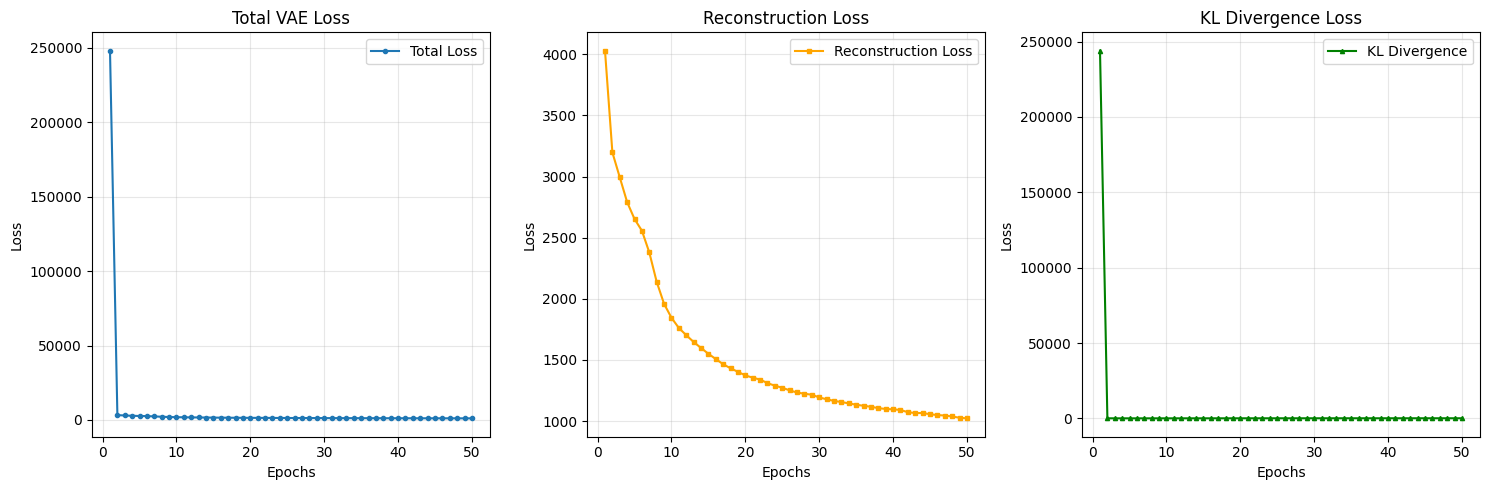

In [16]:
# Plot loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Total Loss", marker='o', markersize=3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Total VAE Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), recon_losses, label="Reconstruction Loss", color='orange', marker='s', markersize=3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Reconstruction Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), kl_losses, label="KL Divergence", color='green', marker='^', markersize=3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("KL Divergence Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

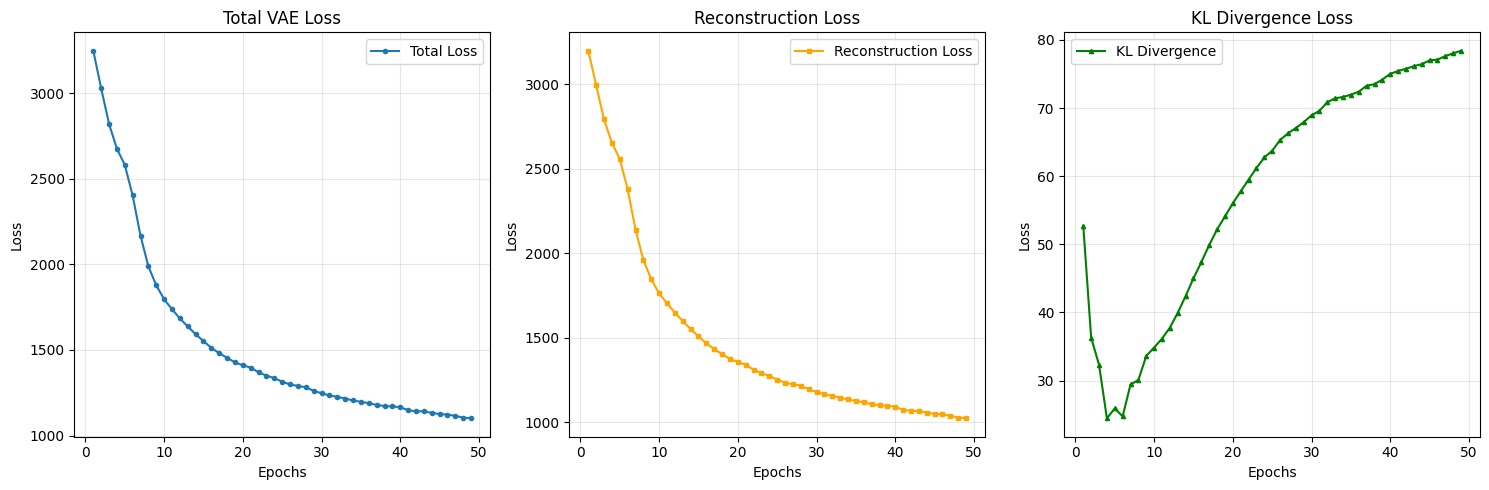

In [22]:
# Plot loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs), train_losses[1:], label="Total Loss", marker='o', markersize=3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Total VAE Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs), recon_losses[1:], label="Reconstruction Loss", color='orange', marker='s', markersize=3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Reconstruction Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs), kl_losses[1:], label="KL Divergence", color='green', marker='^', markersize=3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("KL Divergence Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

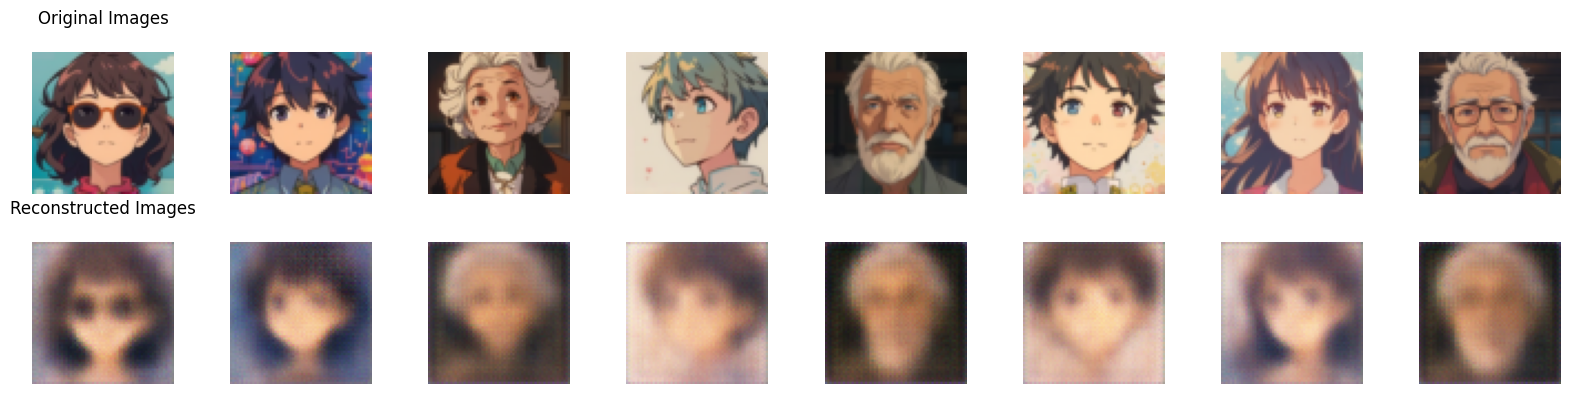

In [17]:
# Function to Display Original vs. Reconstructed Images
def show_original_vs_reconstructed(model, dataloader, device, num_images=8):
    model.eval()

    # Get a batch of images
    images, _ = next(iter(dataloader))
    images = images[:num_images].to(device)

    # Get reconstructed images
    with torch.no_grad():
        reconstructions, _, _ = model(images)

    # Move to CPU and denormalize
    images = denormalize(images.cpu())
    reconstructions = denormalize(reconstructions.cpu())

    # Plot original vs reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        # Original images (Top row)
        img_orig = torch.clamp(images[i].permute(1, 2, 0), 0, 1)
        axes[0, i].imshow(img_orig.numpy())
        axes[0, i].axis("off")

        # Reconstructed images (Bottom row)
        img_recon = torch.clamp(reconstructions[i].permute(1, 2, 0), 0, 1)
        axes[1, i].imshow(img_recon.numpy())
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original Images", fontsize=12, pad=20)
    axes[1, 0].set_title("Reconstructed Images", fontsize=12, pad=20)
    plt.tight_layout()
    plt.show()

# Display Results
show_original_vs_reconstructed(model, train_loader, device)

Let's generate some images:

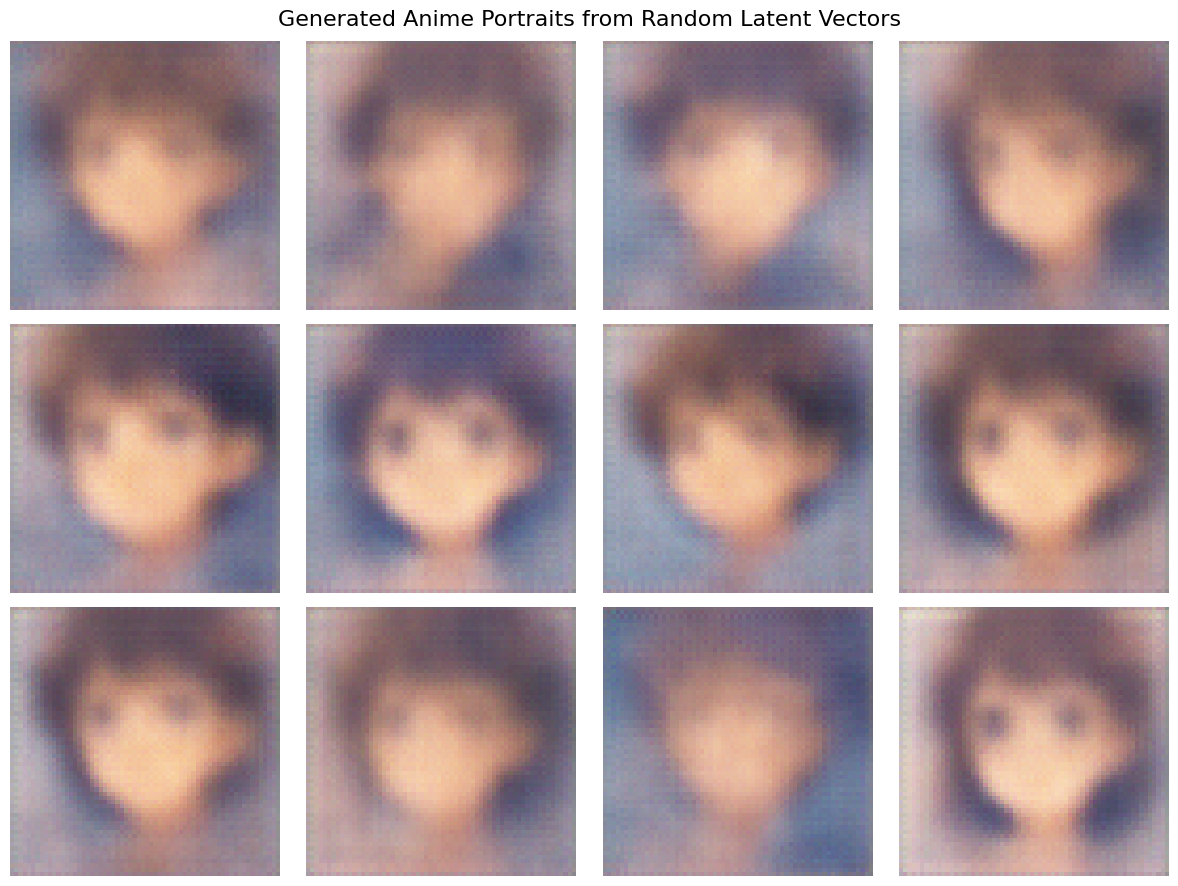

In [18]:
import matplotlib.pyplot as plt

# Function to Generate New Images
def generate_images(model, device, num_images=12, latent_dim=128):
    model.eval()

    # Sample from standard normal distribution
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)
        generated_images = model.decode(z).cpu()

    # Denormalize images
    generated_images = denormalize(generated_images)
    generated_images = torch.clamp(generated_images, 0, 1)

    # Plot generated images
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    for i, ax in enumerate(axes.flat):
        img = generated_images[i].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis("off")

    plt.suptitle("Generated Anime Portraits from Random Latent Vectors", fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate & Display New Anime Images
generate_images(model, device, num_images=12, latent_dim=128)

The quality of generated images heavily depends on the model architecture, latent dimension size, dataset complexity, and training duration. These might not look perfect after a short training run.

## **🔹 Exercise: Effect of Latent Dimension and Beta Parameter**

### **📝 Tasks**
1. **Latent Dimension**: Try different `latent_dim` values (32, 64, 256, 512) - observe the trade-off between compression and quality
2. **Beta Parameter**: Experiment with different `beta` values (0.1, 0.5, 2.0, 10.0) - controls the balance between reconstruction and regularization
3. **Architecture**: Try adding/removing layers or changing filter sizes

### **🎯 Key Observations to Make**
- **Lower latent_dim**: More compression but potentially blurrier results
- **Higher beta**: More regularized latent space but potentially worse reconstruction
- **Lower beta**: Better reconstruction but potentially less structured latent space

### Contributed by: Claude (Updated from Mohamed Eltayeb's original MNIST Autoencoder)

### Contributed by: Ali Habibullah.
(Updated from Mohamed Eltayeb's original MNIST Autoencoder)